In [1]:
from __future__ import absolute_import, unicode_literals, print_function

import dropbot as db
import dropbot.chip
import svg_model

%matplotlib notebook

# Load data frame containing vertices from example SVG file.

In [2]:
# Load data frame containing vertices from example SVG file.
svg_path = db.DATA_DIR.joinpath('SCI-BOTS 90-pin array').joinpath('device.svg')
df_shapes = svg_model.svg_shapes_to_df(svg_path)

# Cast ray from each line segment of each electrode to find neighbour

In [3]:
# Cast ray from each line segment of each electrode to find neighbour within
# threshold distance (default=0.1 mm).
df_intersections = db.chip.get_all_intersections(df_shapes)

# Draw detected neighbours.

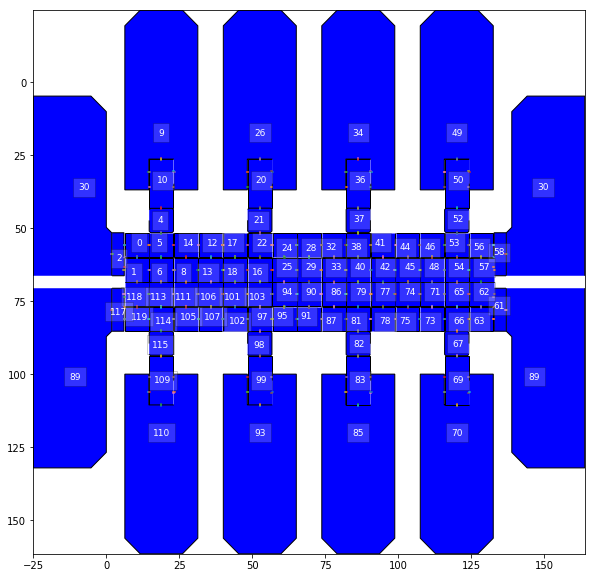

In [4]:
# Draw detected neighbours.
db.chip.draw(df_shapes); pass

# Assign direction labels (i.e., `left`, `right`, `up`, `down`) to neighbours

In [5]:
channel_neighbours = db.chip.get_channel_neighbours(df_shapes)

## Export channel neighbours as `uint8` array

 - One row per channel
 - Each row contains channel numbers for the following neighbour directions:
   `[ up, down, left, right ]`
 - If a channel has no neighbour in a direction, the corresponding neighbour
   channel number is set to -1 (255 as a `uint8`).

In [6]:
channel_neighbours.fillna(-1).astype('uint8').head(16)

channel  direction
0        up           255
         down           1
         left           2
         right          5
1        up             0
         down         118
         left           2
         right          6
2        up           255
         down         255
         left          30
         right          1
3        up           255
         down         255
         left         255
         right        255
Name: channel_neighbour, dtype: uint8